# Guides to LiDAR (Part 6 - Extract building footprints from unclassified LiDAR)



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Step-1.-Create-DSM-and-DTM-Raster-Tiles-With-Buffer" data-toc-modified-id="Step-1.-Create-DSM-and-DTM-Raster-Tiles-With-Buffer-1">Step 1. Create DSM and DTM Raster Tiles With Buffer</a></span></li><li><span><a href="#Step-2.-DSM-and-DTM-to-Composite-Mosaic-Dataset" data-toc-modified-id="Step-2.-DSM-and-DTM-to-Composite-Mosaic-Dataset-2">Step 2. DSM and DTM to Composite Mosaic Dataset</a></span></li><li><span><a href="#Step-3.-Replace-Mosaic-Dataset-Raster-Function-Templates" data-toc-modified-id="Step-3.-Replace-Mosaic-Dataset-Raster-Function-Templates-3">Step 3. Replace Mosaic Dataset Raster Function Templates</a></span></li><li><span><a href="#Step-4.-Extract-Draft-Building-Footprint-Polygons" data-toc-modified-id="Step-4.-Extract-Draft-Building-Footprint-Polygons-4">Step 4. Extract Draft Building Footprint Polygons</a></span></li><li><span><a href="#Step-5.-Regularize-Draft-Building-Footprint-Polygons" data-toc-modified-id="Step-5.-Regularize-Draft-Building-Footprint-Polygons-5">Step 5. Regularize Draft Building Footprint Polygons</a></span></li><li><span><a href="#Step-6.-Validation" data-toc-modified-id="Step-6.-Validation-6">Step 6. Validation</a></span></li><li><span><a href="#Further-Steps" data-toc-modified-id="Further-Steps-7">Further Steps</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-8">Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-9">References</a></span></li></ul></div>

We have explored how to extract building footprints from classified LiDAR data in <a href="lidar_extract_bldgs_classified_part5.ipynb">Part 5</a>. However, for unclassified LiDAR (i.e. when there are no classification codes associated with the LAS dataset), because the point clouds are accumulated information returned from various types of land cover at different heights, which might contain grounds, trees, ..., and even air conditioners, simply transferring the 3d point clouds to 2d raster images (as we talked about in Part 5) would not work as right any more. 

<a href='https://www.semanticscholar.org/paper/Bonemapping%3A-a-LiDAR-processing-and-visualization-Pingel-Clarke/54a67bca35770398b55c05a3df89ecae91e7ef2a'>Thomas Pingel</a> has introduced a new technology called `bonemapping` (shaded slope map) which uses a sort of texture analysis that causes the trees to be much darker for the purpose of better visualization of LiDAR, in creating a bonemap using hillshade combined from different directions at a high altitude with areas below a certain height removed. The bonemap approach also has promised for extracting different roof levels, or even air conditioners on top of roofs <a href="References">[1]</a>. Hence in this notebook, we will use this approach to extract building footprints from unclassified LiDAR. 

## Step 1. Create DSM and DTM Raster Tiles With Buffer

This step is to generate Digital Surface Model (DSM) and Digital Terrain Model (DTM) raster tiles derived from unclassified LiDAR data, and can be split into three functional parts -
  - 1.1 Create LAS Footprints
  - 1.2 Create LAS Dataset
  - 1.3 Create DSM and DTM raster tiles

The functionalities of these three parts are defined individually in the customized methods `create_las_footprints`, `create_las_datasets`, and `create_rasters`, and will be chained and used in the main function `create_dsm_dtm_rasterTiles_buffered`. Please see the detailed implementations in the following:

To start with, let's import necessary libraries, and declare variables and callee functions to be used later.

In [ ]:
import arcpy
import os
import csv
import math

arcpy.env.overwriteOutput = True

In [ ]:
# where you store the original LAS files
in_folder = r"<Root Folder>\3DMappingWithLidarPointClouds\3DMappingWorkshop_IMF2017\20140406_sandy_usgs_de_1986"
# where you output the extracted results
out_folder =  r"<Root Folder>\3DMappingWithLidarPointClouds\3DMappingWorkshop_IMF2017\OutputUnclassified"
# where you download the RFTs
rft_folder = r"<Root Folder>\3DMappingWithLidarPointClouds\3DMappingWorkshop_IMF2017\ExtractUnclassifiedForBuildings\.idea"
# where gdb is created
gdb_location = os.path.join(out_folder, "UnclassifiedBuildingMosaics.gdb")

In [ ]:
cell_size = 2
spatial_ref_string = "PROJCS['NAD_1983_StatePlane_Delaware_FIPS_0700_Feet',GEOGCS['GCS_North_American_1983',DATUM['D_North_American_1983',SPHEROID['GRS_1980',6378137.0,298.257222101]],PRIMEM['Greenwich',0.0],UNIT['Degree',0.0174532925199433]],PROJECTION['Transverse_Mercator'],PARAMETER['False_Easting',656166.6666666665],PARAMETER['False_Northing',0.0],PARAMETER['Central_Meridian',-75.41666666666667],PARAMETER['Scale_Factor',0.999995],PARAMETER['Latitude_Of_Origin',38.0],UNIT['Foot_US',0.3048006096012192]];-17792300 -46619000 3048.00609601219;-100000 10000;-100000 10000;3.28083333333333E-03;0.001;0.001;IsHighPrecision"

In [ ]:
def create_folder(folder):
    '''Create folder'''
    folder = os.path.join(out_folder, folder)
    if not os.path.exists(folder):
        os.makedirs(folder)
    return folder

def create_GDB(gdb_name):
    '''Create geodatabase'''
    gdb = os.path.join(out_folder, gdb_name)
    if not arcpy.Exists(gdb):
        arcpy.AddMessage('Creating geodatabase: {}'.format(gdb_name))
        arcpy.CreateFileGDB_management(out_folder, gdb_name)
    return gdb

In [ ]:
def create_las_footprints(files_to_process, las_extent, las_extent_buff, suffix, spatial_ref, cell_size):
    '''Create LAS footprints'''
    arcpy.AddMessage('Creating LAS Footprints...')
    arcpy.PointFileInformation_3d(input = ';'.join(files_to_process), 
                                  las_extent, 
                                  in_file_type = "LAS", 
                                  file_suffix = suffix, 
                                  input_coordinate_system = spatial_ref, 
                                  folder_recursion = "NO_RECURSION", 
                                  extrude_geometry = "NO_EXTRUSION", 
                                  decimal_separator = "DECIMAL_POINT", 
                                  summarize_by_class_code = "NO_SUMMARIZE", 
                                  improve_las_point_spacing = "NO_LAS_SPACING")
    #Buffer the footprints
    buffer_distance = '{}'.format(math.ceil(float(cell_size) * 10))
    arcpy.Buffer_analysis(las_extent, las_extent_buff, buffer_distance)
    arcpy.Delete_management(las_extent)
    return

In [ ]:
def create_las_datasets(files_to_process, las_dataset, spatial_ref, class_codes=[]):
    '''Create LAS Dataset'''
    arcpy.AddMessage('Creating LAS Dataset...')
    arcpy.CreateLasDataset_management(input = ';'.join(files_to_process), 
                                      out_las_dataset = las_dataset, 
                                      folder_recursion = "NO_RECURSION", 
                                      in_surface_constraints = None, 
                                      spatial_reference = spatial_ref, 
                                      compute_stats = "COMPUTE_STATS", 
                                      relative_paths = "RELATIVE_PATHS", 
                                      create_las_prj = "NO_FILES")
    # Get LiDAR class codes
    las_stats = os.path.join(out_folder, 'lasStats_stats.csv')
    if arcpy.Exists(las_stats):
        arcpy.Delete_management(las_stats)
    arcpy.LasDatasetStatistics_management(las_dataset, "OVERWRITE_EXISTING_STATS", 
                                          las_stats, "DATASET", 
                                          "COMMA", "DECIMAL_POINT")
    with open(lasStats, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if len(row) > 1 and row[1] == 'ClassCodes':
                class_num, class_name = row[0].split('_', 1)
                if not 'reserved' in class_name.lower() and not 'noise' in class_name.lower():
                    class_codes.append(int(class_num))
    arcpy.AddMessage('Class codes: {}'.format(class_codes))
    arcpy.Delete_management(las_stats)
    return

In [ ]:
def create_rasters(files_to_process, las_dataset, class_codes, las_extent_buff, 
                   dsm_raster_folder, dtm_raster_folder, cell_size):
    '''Create DTM and DSM rasters'''
    arcpy.AddMessage('Creating Rasters...')
    if len(class_codes) > 0:
        dsm_layer = 'LasDsm'
        arcpy.MakeLasDatasetLayer_management(in_las_dataset = las_dataset, 
                                             out_layer = dsm_layer, 
                                             class_code = class_codes, 
                                             return_values = "'Last Return'",
                                             no_flag = "INCLUDE_UNFLAGGED", 
                                             synthetic = "INCLUDE_SYNTHETIC", 
                                             keypoint = "INCLUDE_KEYPOINT",
                                             withheld = "EXCLUDE_WITHHELD", 
                                             surface_constraints = None, 
                                             overlap = "INCLUDE_OVERLAP")
    else:
        arcpy.AddWarning('   No DSM Class Codes found. DSM skipped')

    if 2 in class_codes:
        dtm_layer = 'LasDtm'
        arcpy.MakeLasDatasetLayer_management(in_las_dataset = las_dataset, 
                                             out_layer = dtm_layer, 
                                             class_code = 2, 
                                             return_values = "", 
                                             no_flag = "INCLUDE_UNFLAGGED", 
                                             synthetic = "INCLUDE_SYNTHETIC", 
                                             keypoint = "INCLUDE_KEYPOINT",
                                             withheld = "EXCLUDE_WITHHELD", 
                                             surface_constraints = None, 
                                             overlap = "INCLUDE_OVERLAP")
    else:
        arcpy.AddError('   No points classified as GROUND (2). DTM skipped')

    with arcpy.da.UpdateCursor(las_extent_buff, ["FileName", "shape@"]) as cursor:
        for i, row in enumerate(cursor):
            file_name = os.path.splitext(row[0])[0]
            arcpy.env.extent = row[1].extent
            # Create DSM
            arcpy.AddMessage('    Creating DSM {} of {}  ({})'.format(i+1, len(files_to_process), file_name))
            if len(classCodes) > 0:
                out_raster = os.path.join(dsm_raster_folder, "dsm_{}.tif".format(file_name))
                arcpy.LasDatasetToRaster_conversion(in_las_dataset = dsm_ayer, 
                                                    out_raster = out_raster, 
                                                    value_field = "ELEVATION", 
                                                    interpolation_type = "BINNING AVERAGE LINEAR", 
                                                    data_type = "FLOAT", 
                                                    sampling_type = "CELLSIZE", 
                                                    sampling_value = cell_size, 
                                                    z_factor = 1)
                ##Set snapRaster
                arcpy.env.snapRaster = out_raster
            arcpy.SetProgressorPosition()
            # Create DTM
            arcpy.AddMessage('    Creating DTM {} of {}  ({})'.format(i+1, len(files_to_process), file_name))
            if 2 in classCodes:            
                out_raster = os.path.join(dtm_raster_folder, 'dtm_{0}.tif'.format(file_name))
                arcpy.LasDatasetToRaster_conversion(in_las_dataset = dtm_ayer, 
                                                    out_raster = out_raster, 
                                                    value_field = "ELEVATION", 
                                                    interpolation_type = "TRIANGULATION LINEAR NO_THINNING MAXIMUM 0", 
                                                    data_type = "FLOAT", 
                                                    sampling_type = "CELLSIZE", 
                                                    sampling_value = cell_size, 
                                                    z_factor = 1)
            arcpy.SetProgressorPosition()
    arcpy.Delete_management(las_dataset)
    arcpy.Delete_management(dtm_layer)
    arcpy.Delete_management(dsm_layer)
    return

Now all required parameters and customized functions have been declared, we can go onto define the main function for creating DSM and DTM raster tiles:

In [ ]:
def create_dsm_dtm_rasterTiles_buffered(in_folder, out_folder, spatial_ref_string, cell_size):
    '''main function to call customized methods create_las_footprints, create_las_datasets, and create_rasters'''
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)

    # Obtain LiDAR tile Info from Folder
    file_names = []
    lasCount = 0
    zlasCount = 0
    for fileName in os.listdir(in_folder):
        if fileName.endswith('.zlas'):
            zlasCount = zlasCount + 1
            file_names.append(fileName)
        if fileName.endswith('.las'):
            lasCount = lasCount + 1
            file_names.append(fileName)

    # Check that LiDAR tiles exist in folder directory location
    arcpy.SetProgressor("step", "Processing Tiles...", 0, len(file_names), 1)
    if lasCount == 0 and zlasCount == 0:
        arcpy.AddMessage("Cancelling Process as 0 LAS or zLAS tiles detected")
        exit()
    elif lasCount > 0 and zlasCount > 0:
        arcpy.AddMessage("Cancelling Process as {0} zLAS and {1} LAS files detected in process".format(zlasCount, lasCount))
        exit()
    else:
        # Process the LAS files
        spatial_ref = arcpy.SpatialReference()
        spatial_ref.loadFromString(spatial_ref_string)
        files_to_process = [os.path.join(in_folder, las_file) for las_file in file_names]
        suffix = os.path.splitext(file_names[0])[1].replace('.','')

        # Set names/values
        class_codes = []
        out_GDB = createGDB('DsmDtm.gdb')
        las_extent = os.path.join(out_GDB, 'tempTiles')
        las_extent_buff = os.path.join(out_GDB, 'Tiles')
        dsm_raster_folder = createFolder('DSM_Rasters')
        dtm_raster_folder = createFolder('DTM_Rasters')
        las_dataset = os.path.join(out_folder, 'LAS_Dataset.lasd')

        #2x las files [UPDATE THIS] plus 1 for creating footprints, lasDatasets, mosaics 
        processing_steps = (len(file_names)*2) + 3  
        arcpy.SetProgressor('step', 'Processing Files...', 0, processing_steps, 1)

        arcpy.SetProgressorLabel('Creating footprints')
        create_las_footprints(files_to_process, las_extent, las_extent_buff, suffix, spatial_ref, cell_size)
        arcpy.SetProgressorPosition()

        arcpy.SetProgressorLabel('Creating LAS Datasets')
        create_las_datasets(files_to_process, las_dataset, spatial_ref, class_codes)
        arcpy.SetProgressorPosition()

        arcpy.SetProgressorLabel('Creating Rasters')
        create_rasters(files_to_process, las_dataset, class_codes, las_extent_buff, 
                       dsm_raster_folder, dtm_raster_folder, cell_size)

    arcpy.ResetProgressor()
    arcpy.AddMessage('Script Complete')
    exit()

Here, call the main function `create_dsm_dtm_rasterTiles_buffered` with input arguments declared earlier:

In [ ]:
create_dsm_dtm_rasterTiles_buffered(in_folder, out_folder, spatial_ref_string, cell_size)

With DSM and DTM raster tiles created, we can then add the imageries onto maps separately to see the difference. For example, Fig 1 shows a plain basemap (on the left), DSM overlayed on top of basemap (in the middle), and DTM overlayed on top of basemap (on the right).

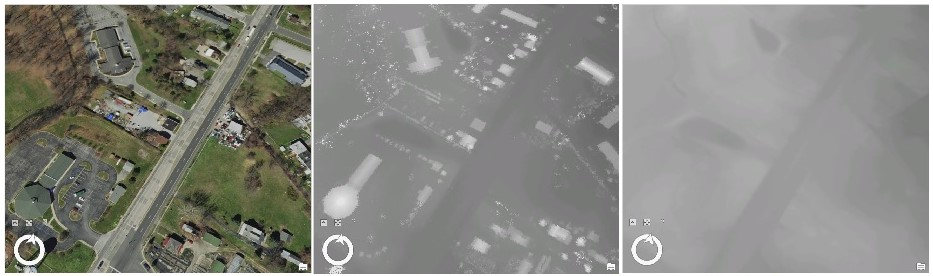
Fig 1. Map area displays a plain basemap (on the left), DSM overlayed on top of basemap (in the middle), and DTM overlayed on top of basemap (on the right)

## Step 2. DSM and DTM to Composite Mosaic Dataset

This step is to create an empty mosaic dataset, then add with both the DTM and DSM rasters (created in step 1).

In [ ]:
def dsm_dtm_to_composite_mosaic_DS(dtm_folder, dsm_folder, out_folder, gdb_name, spatial_ref):
    '''creates a mosaic dataset with both the DTM and DSM rasters'''
    mosaic_name = 'DsmDtm_composite'

    # Check gdb name and delete if exists
    if not gdb_name.endswith('.gdb'):
        gdb_name = '{}.gdb'.format(gdb_name)
    gdb = os.path.join(out_folder, gdb_name)
    if arcpy.Exists(gdb):
        arcpy.Delete_management(gdb)
    arcpy.CreateFileGDB_management(out_folder, gdb_name, "CURRENT")
    arcpy.AddMessage('Geodatabase {} creatred...'.format(gdb_name))

    # Create mosaic dataset    
    arcpy.CreateMosaicDataset_management(in_workspace = gdb, 
                                         in_mosaicdataset_name = mosaic_name, 
                                         coordinate_system = spatial_ref, 
                                         num_bands = None, 
                                         pixel_type = "32_BIT_FLOAT", 
                                         product_definition = "CUSTOM", 
                                         product_band_definitions = None)
    mosaic_DS = os.path.join(gdb, mosaic_name)
    arcpy.AddMessage('Mosaic dataset {} created...'.format(mosaic_name))

    # Add rasters to mosaic and set cell size
    for surface in [('DTM', dtm_folder), ('DSM', dsm_folder)]:
        files = [f for f in os.listdir(surface[1]) if f.endswith('.tif')]
        if len(files) == 0:
            arcpy.AddError('Adding {} {} rasters to mosaic dataset...'.format(len(files), surface[0]))
        else:
            arcpy.AddMessage('Adding {} {} rasters to mosaic dataset...'.format(len(files), surface[0]))
        arcpy.AddRastersToMosaicDataset_management(in_mosaic_dataset = mosaic_DS, 
                                               raster_type = "Raster Dataset", 
                                               input_path = surface[1],
                                               update_cellsize_ranges = "UPDATE_CELL_SIZES", 
                                               update_boundary = "UPDATE_BOUNDARY", 
                                               update_overviews = "NO_OVERVIEWS", 
                                               maximum_pyramid_levels = None, 
                                               maximum_cell_size = 0, 
                                               minimum_dimension = 1500,
                                               spatial_reference = None, 
                                               filter = None, 
                                               sub_folder = "SUBFOLDERS", 
                                               duplicate_items_action = "ALLOW_DUPLICATES", 
                                               build_pyramids = "BUILD_PYRAMIDS", 
                                               calculate_statistics = "CALCULATE_STATISTICS",
                                               build_thumbnails = "NO_THUMBNAILS", 
                                               operation_description = None, 
                                               force_spatial_reference = "NO_FORCE_SPATIAL_REFERENCE", 
                                               estimate_statistics = "ESTIMATE_STATISTICS", 
                                               aux_inputs = None)

    # Update mosaic cell size
    arcpy.AddMessage('Updating mosaic cell size...')
    cell_size = arcpy.GetRasterProperties_management(mosaic_DS, "CELLSIZEX")
    new_size = float(float(cell_size.getOutput(0))/2)
    arcpy.SetMosaicDatasetProperties_management(mosaic_DS, cell_size= new_size)

    # Set the mosaic Tag field to surface type and ZOrder
    arcpy.AddMessage('Setting mosaic dataset Tags...')
    with arcpy.da.UpdateCursor(mosaic_DS, ['Name', 'Tag', 'ZOrder']) as cursor:
        for row in cursor:
            if 'dsm' in row[0].lower():
                row[1] = 'DSM'
                row[2] = 1
            elif 'dtm' in row[0].lower():
                row[1] = 'DTM'
                row[2] = 2
            cursor.updateRow(row)

    arcpy.AddMessage('Process complete')

With `dsm_dtm_to_composite_mosaic_DS` declared, we can now call it with input arguments - dtm_folder, dsm_folder, out_folder, gdb_name, and spatial_ref.

In [ ]:
dsm_dtm_to_composite_mosaic_DS(dtm_folder = os.path.join(out_folder, "DSM_Rasters"), 
                               dsm_folder = os.path.join(out_folder, "DTM_Rasters"), 
                               out_folder = out_folder, 
                               gdb_name = "UnclassifiedBuildingMosaics", 
                               spatial_ref = spatial_ref_string)

The composite mosaic dataset we just created would be looking like Fig 2, if added to and viewed in ArcGIS Pro.

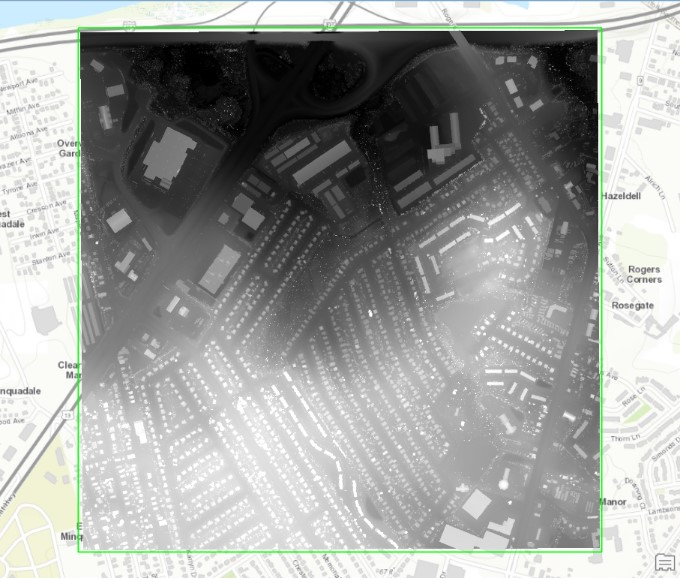
Fig 2. Composite Mosaic Dataset viewed in ArcGIS Pro.

## Step 3. Replace Mosaic Dataset Raster Function Templates

This step is to apply a function chain to the mosaic dataset that extracts possible buildings from DTM and DSM based on height.

A `raster function template` (RFT) is used here to extract buildings from the mosaic dataset using `MultiDirectional Hillshade` from DSM and DTM with a filter in elevation. Several RFTs are pre-made and shared onto the target enterprise, e.g. `Extract Buildings Using MultiDirectional Hillshade from DSM and DTM Feet over 8ft`, or `Extract Buildings Using MultiDirectional Hillshade from DSM and DTM Feet over 12ft`, etc. The only difference between these RFTs is the bar set for the minimum height at which building are detected. As shown in Fig 3, the only difference between these RFTs is that the minimum height set for the remapping step is varied. In general, try different templates (starting with 8ft) to determine the best option to accurately detect buildings in your data. 

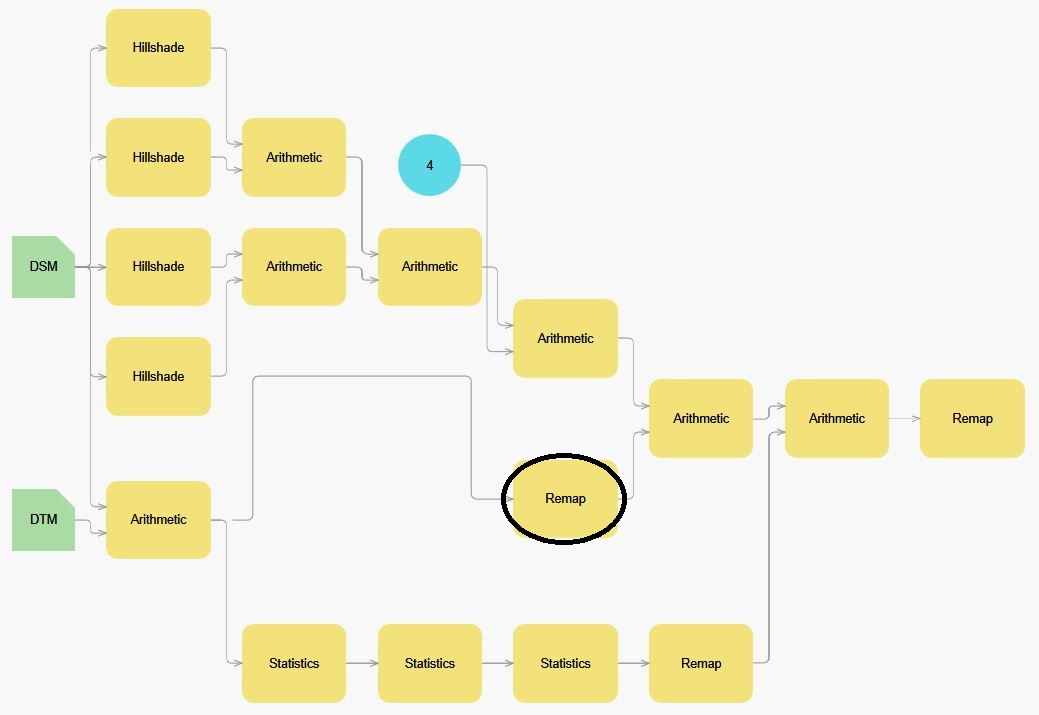
Fig 3. Workflow graph showing raster functions being chained in the RFT.

Before we apply a function chain to the mosaic dataset, let's first access the raster function template file (published on ArcGIS Online or enterprise), and download into a local directory:

In [1]:
from arcgis.gis import GIS
gis = GIS("https://pythonapi.playground.esri.com/portal")

In [2]:
rft_item1 = gis.content.get("52c6b0f8715b40f993d61c441df8e996")
rft_item1

<Item title:"Extract Buildings Using MultiDirectional Hillshade from DSM and DTM Feet over 8ft" type:Raster function template owner:api_data_owner>

In [3]:
rft_item2 = gis.content.get("c64afe9cf1444f67b64fdff649b2fb89")
rft_item2

<Item title:"Extract Buildings Using MultiDirectional Hillshade from DSM and DTM Feet over 12ft" type:Raster function template owner:api_data_owner>

In [ ]:
# Check to ensure that download folder exists:
if not os.path.exists(rft_folder):
    os.makedirs(rft_folder)
# download the RFT item into local folder
for item in [rft_item1, rft_item2]:
    item.download(save_path=rft_folder)

In residential areas where single-storied buildings are, it is best to set it low (8 feet or so). In areas with mostly taller buildings, try to use a higher height (like 13 feet or 4 meters) to minimize the trees more. Though in both cases, some trees will still come in. 

An additional step sometimes that can be done to remove trees is to do an NDVI (from NAIP imagery) and using your output Draft Polygons as input to Zonal Statistics to add the NDVI mean value to the buildings. You can then select by smaller sizes and NDVI values to find these to delete. We will not cover that in this notebook. 

Also in areas where you have loading docks where semi-trailers are next to buildings, setting a height above the semi-trucks will remove the features from the buildings.

Next, we will re-use a customized function `replace_raster_function_template` first declared in <a href="./lidar_extract_bldgs_classified_part5.ipynb">Part 5</a>, and apply it onto the mosaic dataset as to replace the raster function template with e.g. "Extract Buildings Using MultiDirectional Hillshade from DSM and DTM Feet over 8ft.rft.xml":

In [ ]:
def replace_raster_function_template(mosaic_name, raster_function_name):
    
    desc = arcpy.Describe(mosaic_name)
    if hasattr(desc, "layer"):
        mosaic_DS = desc.layer.catalogPath
    else:
        mosaic_DS = desc.catalogPath

    raster_function = os.path.join(rft_folder, '{}.rft.xml'.format(raster_function_name))

    # Replace the function
    arcpy.AddMessage('Replacing raster function template...')
    arcpy.EditRasterFunction_management(mosaic_DS, "EDIT_MOSAIC_DATASET", "REPLACE", raster_function, '#')

    arcpy.AddMessage('Replacement complete')

In [ ]:
replace_raster_function_template("DsmDtm_composite", 
                                 "Extract Buildings Using MultiDirectional Hillshade from DSM and DTM Feet over 8ft")

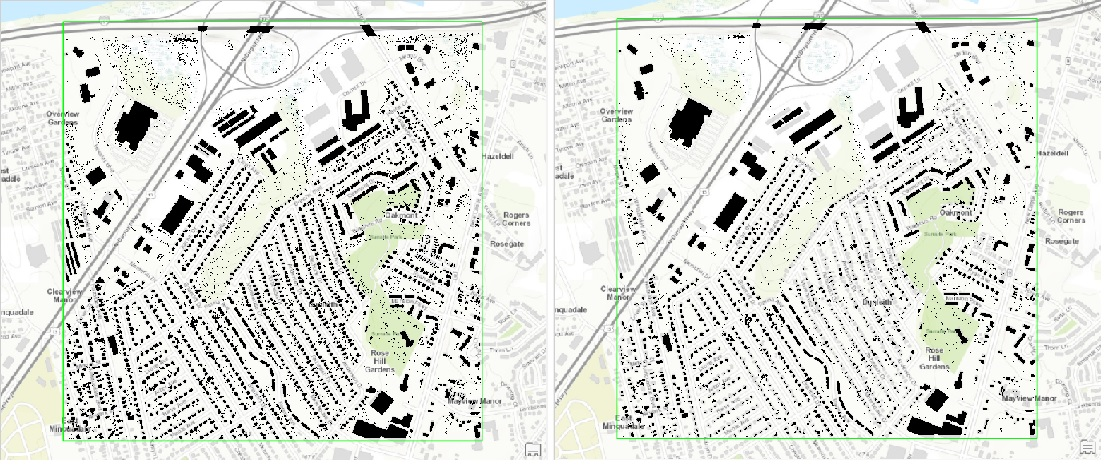
Fig 4. Extracted buildings footprint when minimum height is set at 8ft (on the left), and extracted result when minimum height set at 12ft (on the right).

Comparing the two maps shown above, we can see that the 2nd map (with minimum height set at 12ft) displays less scattered points, which are highly likely to be trees with height of 8-12 feet.

## Step 4. Extract Draft Building Footprint Polygons

This step is to take in the mosaic dataset (of DTM, DSM composite), and transform into an output of polygons. Because the `Simplify Option` is turned off, the output polygon would still contain small polygons (which are less likely to be of buildings) that we are going to eliminate in the next step.

Again, we will re-use a customized function `model` first declared in <a href="./lidar_extract_bldgs_classified_part5.ipynb">Part 5</a>, and apply it onto the output raster of step 3.

In [ ]:
# 4) Extract Draft Building Footprint Polygons
def model(input_raster, output_polygon_features):  

    # To allow overwriting outputs change overwriteOutput option to True.
    arcpy.env.overwriteOutput = False

    simplify_polygons = False

    # Process: Raster to Polygon (Raster to Polygon) 
    arcpy.RasterToPolygon_conversion(in_raster=input_raster, 
                                     out_polygon_features=output_polygon_features, 
                                     simplify=simplify_polygons, 
                                     raster_field="", 
                                     create_multipart_features="SINGLE_OUTER_PART", 
                                     max_vertices_per_feature=None)

In [ ]:
model(input_raster = r"DsmDtm_composite\Image", 
      output_polygon_features = os.path.join(out_folder, "DraftPolygons.shp"))

The `RasterToPolygon_conversion` tool is to extract the buildings from raster format to polygons, and with the polygons set as red outlined, and no color filled, the map looks like what's shown in the figure below.

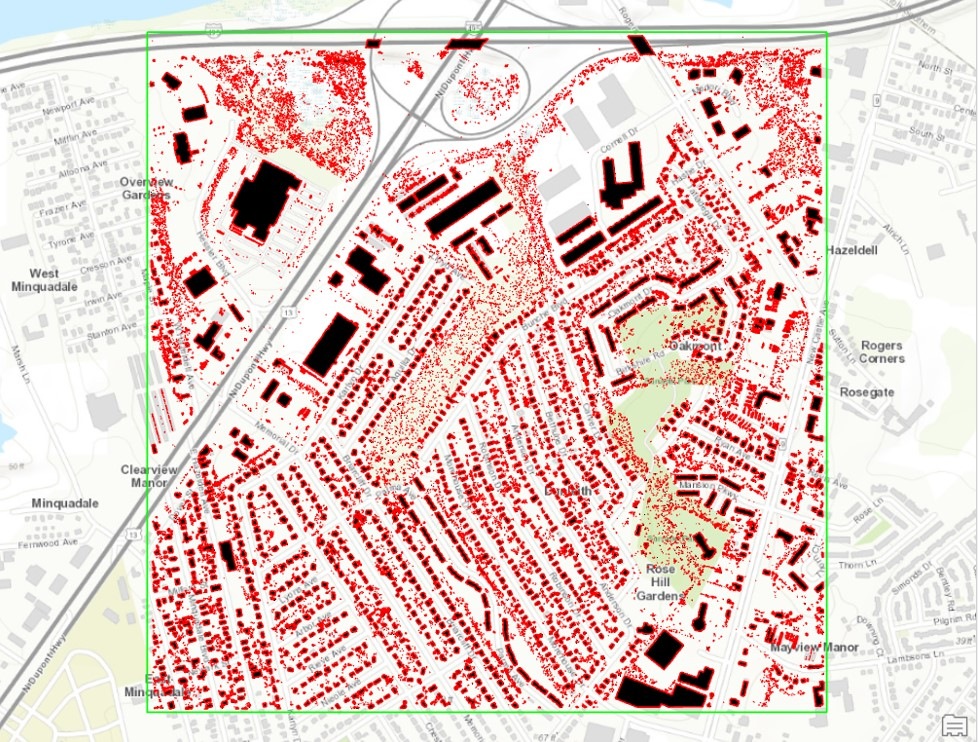
Fig 5. Extracted buildings from raster format to polygons, and with the polygons set as red outlined, and no color filled.

Change the map view from 2D to 3D, and zoom into a smaller area, the extracted buildings polygons overlayed on top of satellite image (basemap) will look like what's shown in Fig 6.

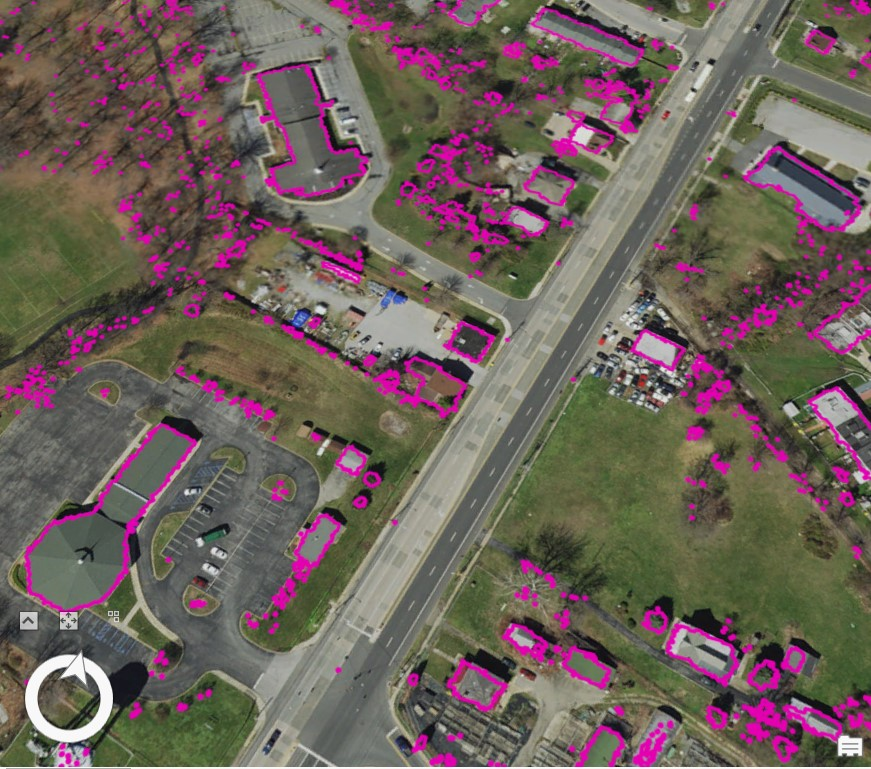
Fig 6. Map zoomed into smaller areas, with the extracted buildings polygons overlayed on top of satellite image (basemap).

The tool `RasterToPolygon_conversion` seemed to be doing a good job here, since most of the buildings are identified. However, we can see the boundaries of these buildings contain too many curves, which is against the facts that most of the exterior rims of buildings are made up of straight lines. Also, Fig 5 and Fig 6 still display trees in the extracted result, that we should still work on removing.

## Step 5. Regularize Draft Building Footprint Polygons

This step uses a complex model that divides the polygons in Small, Medium and Large polygons to process differently. It also finds possible Circle Buildings (tanks, mostly). The Minimum Size Polygons in Square Feet is pre-set to 250, which is equivalent to roughly a 15ft x 15ft building.

The draft polygons being created in Step 4 will be regularized and generalized into a new output `Buildings_Generalized`. We will take advantage of the same workflow being introduced in Step 5 of <a href="./lidar_extract_bldgs_classified_part5.ipynb">Part 5</a>,  as to split the `Draft Polygons` into small-, medium-, and large-sized polygons in performing the regularization, and merge the individual results after processing.

In [ ]:
def regularize_building_footprints_for_circle2(fc_name, gdb_location,
                                               large_tolerance, large_densification, large_method,
                                               large_precision, large_diagonal_penalty, large_definition,
                                               medium_tolerance, medium_densification, medium_method,
                                               medium_precision, medium_diagonal_penalty, medium_definition,
                                               small_tolerance, small_densification, small_method, 
                                               small_precision, small_diagonal_penalty, small_definition,
                                               minimum_size_polygons_in_square_feet):
    """part 1: divide polygons"""
    input2_2_ = os.path.join(gdb_location, fc_name)
    workspace = gdb_location
    # subset of large-sized bldgs
    # Process: Make Feature Layer (3) (Make Feature Layer) 
    circle8 = "input_Layer2"
    arcpy.MakeFeatureLayer_management(in_features=input2_2_, 
                                      out_layer=circle8, 
                                      where_clause=large_definition, 
                                      workspace="", 
                                      field_info="OBJECTID OBJECTID VISIBLE NONE;\
                                      Shape Shape VISIBLE NONE;Id Id VISIBLE NONE;\
                                      gridcode gridcode VISIBLE NONE;Shape_Length Shape_Length VISIBLE NONE;\
                                      Shape_Area Shape_Area VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                      Type Type VISIBLE NONE;Process Process VISIBLE NONE")

    # Process: Regularize Building Footprint (2) (Regularize Building Footprint) 
    circle8_2_ = fr"{workspace}\Circle8"
    with arcpy.EnvManager(extent="DEFAULT"):
        arcpy.RegularizeBuildingFootprint_3d(in_features=circle8, 
                                             out_feature_class=circle8_2_, 
                                             method="CIRCLE", tolerance=large_tolerance, 
                                             densification=None, precision=large_precision, 
                                             diagonal_penalty=large_diagonal_penalty, 
                                             min_radius=0.1, max_radius=1000000)
        
    # Medium polygons
    # Process: Make Feature Layer (5) (Make Feature Layer) 
    circle5 = "input_Layer3"
    arcpy.MakeFeatureLayer_management(in_features=input2_2_, 
                                      out_layer=circle5, 
                                      where_clause=medium_definition, 
                                      workspace="", 
                                      field_info="OBJECTID OBJECTID VISIBLE NONE;\
                                      Shape Shape VISIBLE NONE;Id Id VISIBLE NONE;\
                                      gridcode gridcode VISIBLE NONE;Shape_Length Shape_Length VISIBLE NONE;\
                                      Shape_Area Shape_Area VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                      Type Type VISIBLE NONE;Process Process VISIBLE NONE")

    # Process: Regularize Building Footprint (4) (Regularize Building Footprint) 
    circle5_3_ = fr"{workspace}\Circle5"
    with arcpy.EnvManager(extent="DEFAULT"):
        arcpy.RegularizeBuildingFootprint_3d(in_features=circle5, 
                                             out_feature_class=Ccircle5_3_, 
                                             method="CIRCLE", tolerance=medium_tolerance, 
                                             densification=None, precision=medium_precision, 
                                             diagonal_penalty=medium_diagonal_penalty, 
                                             min_radius=0.1, max_radius=1000000)
    # small polygons
    # Process: Make Feature Layer (5) (Make Feature Layer) 
    circle2 = "input_Layer6"
    arcpy.MakeFeatureLayer_management(in_features=input2_2_, 
                                      out_layer=circle2, 
                                      where_clause=small_definition, 
                                      workspace="", field_info="OBJECTID OBJECTID VISIBLE NONE;\
                                      Shape Shape VISIBLE NONE;Id Id VISIBLE NONE;\
                                      gridcode gridcode VISIBLE NONE;Shape_Length Shape_Length VISIBLE NONE;\
                                      Shape_Area Shape_Area VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                      Type Type VISIBLE NONE;Process Process VISIBLE NONE")

    # Process: Regularize Building Footprint (4) (Regularize Building Footprint) 
    circle2_6_ = fr"{workspace}\Circle2"
    with arcpy.EnvManager(extent="DEFAULT"):
        arcpy.RegularizeBuildingFootprint_3d(in_features=circle2, 
                                             out_feature_class=circle2_6_, 
                                             method="CIRCLE", tolerance=small_tolerance, 
                                             densification=None, precision=small_precision, 
                                             diagonal_penalty=small_diagonal_penalty, 
                                             min_radius=0.1, max_radius=1000000)
    # Process: Merge
    circle_merg = fr"{workspace}\CircleMerg"
    with arcpy.EnvManager(extent="MAXOF"):
        arcpy.Merge_management(inputs=[circle8_2_, circle5_3_, circle2_6_],
                               output = circle_merg,
                               field_mappings=fr"Id \"Id\" true true false 4 Long 0 0,First,#,{workspace}\circle8,\
                                                 Id,-1,-1,{workspace}\circle5,\
                                                 Id,-1,-1,{workspace}\circle2,STATUS,-1,-1",
                               add_source = "NO_SOURCE_INFO")
        
    """part 2: Find Circle buildings"""
    # Process: Make Feature Layer (Make Feature Layer) 
    circle_merg_layer = fr"{workspace}\CircleMerg_Layer"
    arcpy.MakeFeatureLayer_management(in_features=circle_merg, 
                                      out_layer=circle_merg_layer, 
                                      where_clause="\"STATUS\" = 0", 
                                      workspace="", 
                                      field_info="Shape_Leng Shape_Leng VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                      Type Type VISIBLE NONE;Process Process VISIBLE NONE;\
                                      Shape_Length Shape_Length VISIBLE NONE;Shape_Area Shape_Area VISIBLE NONE;\
                                      ORIG_OID ORIG_OID VISIBLE NONE;STATUS STATUS VISIBLE NONE;Id Id VISIBLE NONE;\
                                      gridcode gridcode VISIBLE NONE")

    # Process: Add Geometry Attributes (2) (Add Geometry Attributes) 
    circle_merg_layer_2_ = AddGeometryAttributes(Input_Features=circle_merg_layer, 
                                                Geometry_Properties=["AREA"], 
                                                Length_Unit="FEET_US", 
                                                Area_Unit="SQUARE_FEET_US", 
                                                Coordinate_System="")[0]

    # Process: Sort (Sort) 
    output = fr"{gdb_location}\CircleBuildings"
    with arcpy.EnvManager(extent="DEFAULT"):
        arcpy.Sort_management(in_dataset=circle_merg_layer_2_, 
                              out_dataset=output, 
                              sort_field=[["POLY_AREA", "DESCENDING"]], 
                              spatial_sort_method="UR")

    # Process: Calculate Field (Calculate Field) 
    circle_buildings = arcpy.CalculateField_management(in_table=output, 
                                                      field="Type", 
                                                      expression="'Circle'", 
                                                      expression_type="PYTHON", 
                                                      code_block="", 
                                                      field_type="LONG")[0]
    
    """part 3: regularize the bldgs"""
    # for large-sized bldgs
    # Process: Make Feature Layer (10) (Make Feature Layer) 
    large_raw_buildings = "LargeRawBuildings"
    arcpy.MakeFeatureLayer_management(in_features=input2_2_, 
                                      out_layer=large_raw_buildings, 
                                      where_clause=large_definition, 
                                      workspace="", 
                                      field_info="OBJECTID OBJECTID VISIBLE NONE;Shape Shape VISIBLE NONE;\
                                      Id Id VISIBLE NONE;gridcode gridcode VISIBLE NONE;Shape_Length Shape_Length VISIBLE NONE;\
                                      Shape_Area Shape_Area VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                      Type Type VISIBLE NONE;Process Process VISIBLE NONE")

    # Process: Calculate Field (10) (Calculate Field) 
    large_raw_buildings_3_ = arcpy.CalculateField_management(in_table=large_raw_buildings, 
                                                           field="Type", expression="'Large'", expression_type="PYTHON", 
                                                           code_block="", field_type="LONG")[0]
    
    # Process: Regularize Building Footprint (9) (Regularize Building Footprint) 
    large = fr"{workspace}\Large"
    arcpy.RegularizeBuildingFootprint_3d(in_features=large_raw_buildings_3_, 
                                         out_feature_class=large, 
                                         method=large_method, 
                                         tolerance=large_tolerance, 
                                         densification=large_densification, 
                                         precision=large_precision, 
                                         diagonal_penalty=large_diagonal_penalty, 
                                         min_radius=0.1, max_radius=1000000)

    # Process: Eliminate Polygon Part (Eliminate Polygon Part) 
    large_eliminatePolygonPart = fr"{workspace}\Large_EliminatePolygonPart"
    arcpy.EliminatePolygonPart_management(in_features=large, 
                                          out_feature_class=large_eliminatePolygonPart, 
                                          condition="AREA", 
                                          part_area="200 SquareFeet", 
                                          part_area_percent=0, 
                                          part_option="CONTAINED_ONLY")

    # Process: Simplify Building (Simplify Building) 
    large_simplifyBuildingSB2 = fr"{workspace}\Large_SimplifyBuildingSB2"
    arcpy.SimplifyBuilding_cartography(in_features=large_eliminatePolygonPart, 
                                       out_feature_class=large_simplifyBuildingSB2, 
                                       simplification_tolerance="2 Feet", 
                                       minimum_area="0 SquareMeters", 
                                       conflict_option="NO_CHECK", in_barriers=[])

    # Process: Calculate Field (2) (Calculate Field) 
    large_simplifyBuildingSB2_2_ = arcpy.CalculateField_management(in_table=large_simplifyBuildingSB2, 
                                                                   field="Process", expression="!BLD_STATUS!", 
                                                                   expression_type="PYTHON", code_block="", 
                                                                   field_type="LONG")[0]
    
    # for medium-sized bldgs
    # Process: Make Feature Layer (11) (Make Feature Layer) 
    medium_raw_buildings = "MediumRawBuildings"
    arcpy.MakeFeatureLayer_management(in_features=input2_2_, 
                                      out_layer=medium_raw_buildings, 
                                      where_clause=medium_definition, 
                                      workspace="", 
                                      field_info="OBJECTID OBJECTID VISIBLE NONE;Shape Shape VISIBLE NONE;\
                                      Id Id VISIBLE NONE;gridcode gridcode VISIBLE NONE;Shape_Length Shape_Length VISIBLE NONE;\
                                      Shape_Area Shape_Area VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                      Type Type VISIBLE NONE;Process Process VISIBLE NONE")

    # Process: Calculate Field (11) (Calculate Field) 
    medium_raw_buildings_3_ = arcpy.CalculateField_management(in_table=medium_raw_buildings, 
                                                              field="Type", expression="'Medium'", 
                                                              expression_type="PYTHON", code_block="", 
                                                              field_type="LONG")[0]
    
    # Process: Regularize Building Footprint (10) (Regularize Building Footprint) 
    medium = fr"{workspace}\Medium"
    if large_simplifyBuilding_SB8_2_:
        arcpy.RegularizeBuildingFootprint_3d(in_features=medium_raw_buildings_3_, 
                                             out_feature_class=medium, 
                                             method="RIGHT_ANGLES_AND_DIAGONALS", 
                                             tolerance=medium_tolerance, 
                                             densification=medium_densification, 
                                             precision=medium_precision, 
                                             diagonal_penalty=medium_diagonal_penalty, 
                                             min_radius=0.1, max_radius=1000000)

    # Process: Eliminate Polygon Part (2) (Eliminate Polygon Part) 
    medium_eliminatePolygonPart = fr"{workspace}\Medium_EliminatePolygonPart"
    if large_simplifyBuilding_SB8_2_:
        arcpy.EliminatePolygonPart_management(in_features=medium, 
                                              out_feature_class=medium_eliminatePolygonPart, 
                                              condition="AREA", 
                                              part_area="150 SquareFeet", 
                                              part_area_percent=0, 
                                              part_option="CONTAINED_ONLY")

    # Process: Simplify Building (5) (Simplify Building) 
    medium_simplifyBuildingSB2 = fr"{workspace}\Medium_SimplifyBuildingSB2"
    if large_simplifyBuilding_SB8_2_:
        arcpy.SimplifyBuilding_cartography(in_features=medium_eliminatePolygonPart, 
                                           out_feature_class=medium_simplifyBuildingSB2, 
                                           simplification_tolerance="2 Feet", 
                                           minimum_area="0 SquareMeters", 
                                           conflict_option="NO_CHECK", in_barriers=[])

    # Process: Calculate Field (6) (Calculate Field) 
    if large_simplifyBuilding_SB8_2_:
        medium_simplifyBuildingSB2_3_ = arcpy.CalculateField_management(in_table=medium_simplifyBuildingSB2, 
                                                                        field="Process", expression="!BLD_STATUS!", 
                                                                        expression_type="PYTHON", code_block="", 
                                                                        field_type="LONG")[0]
        
    # for small-sized bldgs
    # Process: Make Feature Layer (12) (Make Feature Layer) 
    small_raw_buildings = "SmallRawBuildings"
    arcpy.MakeFeatureLayer_management(in_features=input2_2_, 
                                      out_layer=small_raw_buildings, 
                                      where_clause=small_definition, 
                                      workspace="", 
                                      field_info="OBJECTID OBJECTID VISIBLE NONE;Shape Shape VISIBLE NONE;\
                                      Id Id VISIBLE NONE;gridcode gridcode VISIBLE NONE;Shape_Length Shape_Length VISIBLE NONE;\
                                      Shape_Area Shape_Area VISIBLE NONE;POLY_AREA POLY_AREA VISIBLE NONE;\
                                      Type Type VISIBLE NONE;Process Process VISIBLE NONE")

    # Process: Calculate Field (12) (Calculate Field) 
    small_raw_buildings_3_ = arcpy.CalculateField_management(in_table=small_raw_buildings, 
                                                             field="Type", expression="'Small'", 
                                                             expression_type="PYTHON", code_block="", 
                                                             field_type="LONG")[0]
    
    # Process: Regularize Building Footprint (11) (Regularize Building Footprint) 
    small = fr"{workspace}\Small"
    arcpy.RegularizeBuildingFootprint_3d(in_features=small_raw_buildings_3_, 
                                         out_feature_class=small, 
                                         method=smalll_method, 
                                         tolerance=small_tolerance, 
                                         densification=small_densification, 
                                         precision=small_precision, 
                                         diagonal_penalty=small_diagonal_penalty, 
                                         min_radius=0.1, max_radius=1000000)

    # Process: Eliminate Polygon Part (3) (Eliminate Polygon Part) 
    small_eliminatePolygonPart = fr"{workspace}\Small_EliminatePolygonPart"
    arcpy.EliminatePolygonPart_management(in_features=small, 
                                          out_feature_class=small_eliminatePolygonPart, 
                                          condition="AREA", part_area="50 SquareFeet", 
                                          part_area_percent=0, part_option="CONTAINED_ONLY")

    # Process: Simplify Building (8) (Simplify Building) 
    small_simplifyBuildingSB2 = fr"{workspace}\Small_SimplifyBuildingSB2"
    arcpy.SimplifyBuilding_cartography(in_features=small_eliminatePolygonPart, 
                                       out_feature_class=small_simplifyBuildingSB2, 
                                       simplification_tolerance="2 Feet", 
                                       minimum_area="0 SquareMeters", 
                                       conflict_option="NO_CHECK", in_barriers=[])

    # Process: Calculate Field (8) (Calculate Field) 
    small_simplifyBuildingSB2_2_ = arcpy.CalculateField_management(in_table=small_simplifyBuildingSB2, 
                                                                   field="Process", expression="!BLD_STATUS!", 
                                                                   expression_type="PYTHON", code_block="", 
                                                                   field_type="LONG")[0]
    
    # merge all output
    output_2_ = fr"{gdb_location}\Buildings"
    if large_simplifyBuilding_SB8_2_:
        with arcpy.EnvManager(extent="MAXOF"):
            arcpy.Merge_management(inputs=[large_simplifyBuilding_SB8_2_, 
                                           medium_simplifyBuilding_SB4_2_, 
                                           small_simplifyBuilding_SB2_2_], 
                                   output=output_2_)
            
    """part 4: generalize"""
    # Process: Regularize Building Footprint (12) (Regularize Building Footprint) 
    buildings_9_ = output_2_
    building_generalized = fr"{gdb_location}\Building_generalized"
    if large_simplifyBuilding_SB8_2_:
        with arcpy.EnvManager(extent="DEFAULT"):
            arcpy.RegularizeBuildingFootprint_3d(in_features=buildings_9_, 
                                                 out_feature_class=building_generalized, 
                                                 method="RIGHT_ANGLES_AND_DIAGONALS", 
                                                 tolerance=3, densification=1.5, 
                                                 precision=0.25, diagonal_penalty=1.5, 
                                                 min_radius=0.1, max_radius=1000000)

In [ ]:
regularize_building_footprints_for_circle2("DraftPolygons", 
                                           gdb_location, 
                                           large_tolerance = 4
                                           large_densification = 4, 
                                           large_method = "RIGHT_ANGLES_AND_DIAGONALS", 
                                           large_precision = 0.25, 
                                           large_diagonal_penalty = 1.5, 
                                           large_definition = '"POLY_AREA" > 25000', 
                                           medium_tolerance = 3, 
                                           medium_densification = 3, 
                                           medium_method = "RIGHT_ANGLES_AND_DIAGONALS", 
                                           medium_precision = 0.25, 
                                           medium_diagonal_penalty = 1.5, 
                                           medium_definition = '"POLY_AREA" > 5000 AND "POLY_AREA" <= 25000', 
                                           small_tolerance = 2, 
                                           small_densification = 2, 
                                           small_method = "RIGHT_ANGLES", 
                                           small_precision = 0.25, 
                                           small_diagonal_penalty = 1.5, 
                                           small_definition = '"POLY_AREA" <= 5000 AND "POLY_AREA" > 25',
                                           minimum_size_polygons_in_square_feet = 250)

The final output of method `regularize_building_footprints_for_circle2` creates the `Buildings_Generalized` in the file gdb, and we can add it to mapping area and set the symbology to be of orange outlined, and no color filled, then the generalized buildings being overlaid on the satellite imagery would look like -

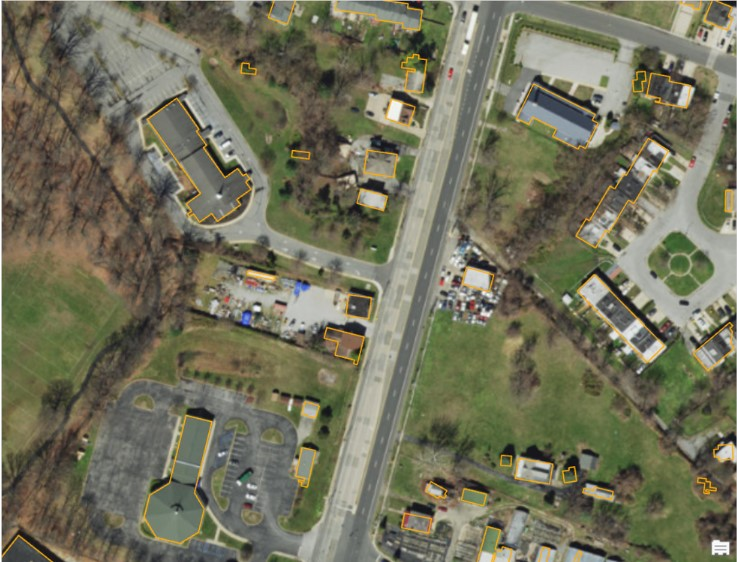
Fig 7. Generalized buildings overlaid on top of satellite image.

Also, if we overlay the `generalized buildings` layer on top of the extracted footprint (raster) and the draft buildings (vector), the map looks like -

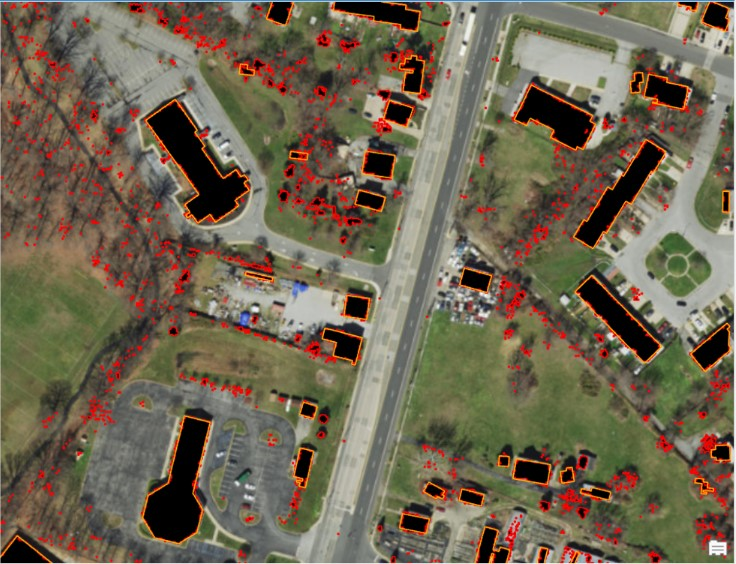
Fig 8. Generalized buildings compared to the draft buildings, overlaid on top of the buildings footprint.

We can see how the shape of buildings got simplified and smoothed out - especially that building footprints with area<250 square feet are excluded from the selection.

## Step 6. Validation

It is important to examine the results and check for accuracy after extract, regularization and simplification, and it can usually be done by visual comparisons. Besides the comparison results shown in Fig 7 and Fig 8, we can also compare the `Generalized Buildings` output with the bonemap (which is created by running Step 3 with with `MultiDirectional Hillshade_feet` Raster Processing Template). As shown below in Fig 9, the `bonemap` is visualized with `DRA` symbology.

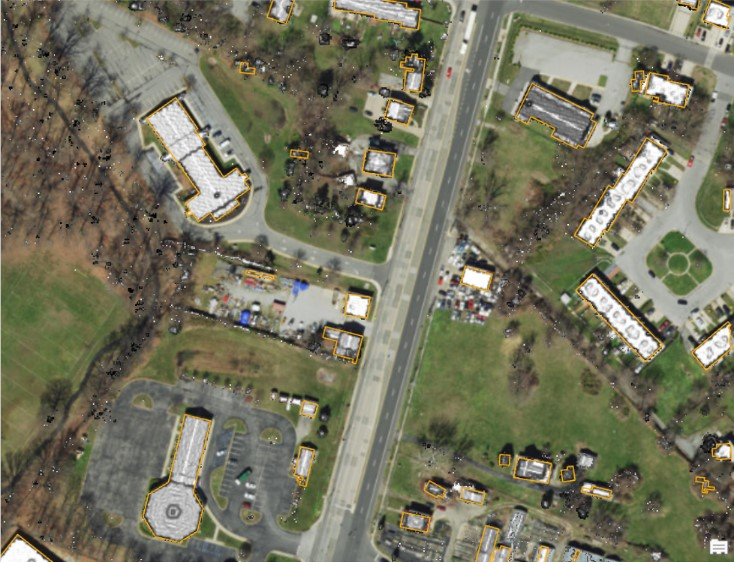
Fig 9. Generalized buildings compared with bonemap.

## Further Steps

After the building footprints have been created, there are multiple steps we can apply to reconstruct a 3d view of the scene represented by the LiDAR point clouds, e.g. extracting roof forms, and creating 3d trees. `ArcGIS Learn Lessons` provides detailed walk through to extract roof forms and create 3d trees, so we are not going to cover these topics here. Feel free to check out the details at the ArcGIS Learn Lessons Gallery<a href="#References">[2]</a>.

  - Extract Roof Forms
    - Create Normalized Digital Surface Model
    - Calculate Building Roof Form
    - Features From CityEngine Rules
  - Create 3D Trees
    - Create LAS Dataset
    - Tree Point Extraction
    - Create 3D Trees
  

With Roof Forms added:

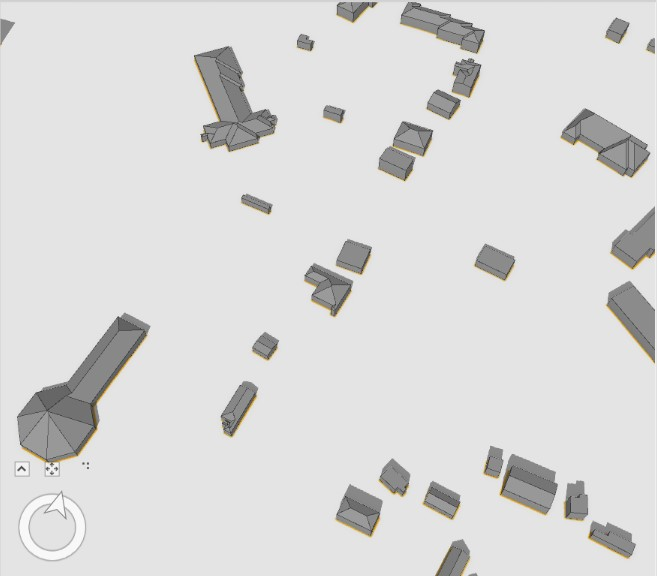
Fig 10. Roof forms extracted for the generalized buildings, with shadows added.

With Thematic Trees added:

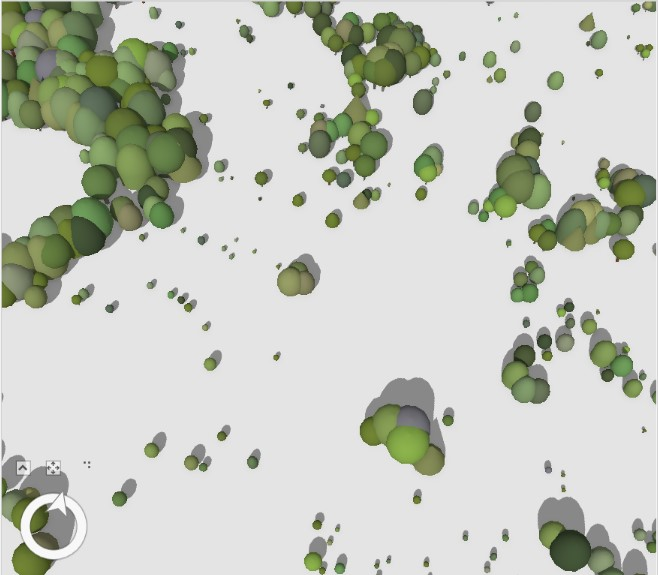
Fig 11. Tree points extracted from the draft polygons, and being rendered with thematic trees style.

The final outcome with 3d reconstructions of buildings and trees will look like -

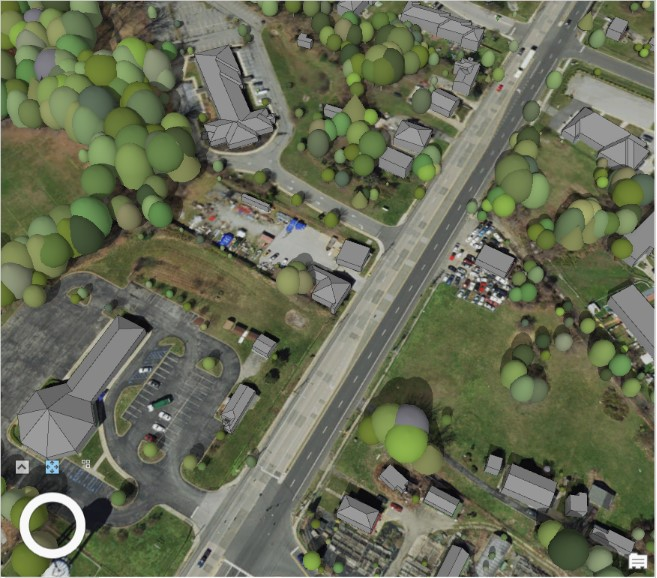
Fig 12. Roof forms and Tree points both added to mapping area, overlaid on top of the satellite image.

## Conclusions

This notebook demonstrates a common workflow in extracting buildings from unclassified LiDAR data. The procedures being introduced here include, (1) creating DSM and DTM Raster Tiles With Buffer, (2) composite Mosaic Dataset from DSM and DTM, (3) perform multi-leveled smoothing using a customized tool that replaces Raster Function Template being applied in the Mosaic Dataset, (4) extracting Draft Building Footprint Polygons, and (5) regularizing Draft Building Footprint Polygons. In the last step, divide-and-conquer mechanism has been used to achieve better efficiency and higher accuracy, by splitting the problem set into large, medium, and small-sized buildings. Last but not least, performing validation of the final extracted results is critical in achieving higher accuracy and in the same time avoiding overfitting.

We have discussed how to extract buildings from LiDAR point clouds with and without classification information, in <a href="">Part 5</a> and Part 6. If interested in learning more, please browse `ArcGIS Learn Lessons Gallery` <a href="#References">[2]</a>.

## References

[1] Pingel, Clarke & Ford, "Bonemapping: a LiDAR processing and visualization technique in support of archaeology under the canopy", https://www.semanticscholar.org/paper/Bonemapping%3A-a-LiDAR-processing-and-visualization-Pingel-Clarke/54a67bca35770398b55c05a3df89ecae91e7ef2a

[2] ArcGIS Learn Lessons, "Extract Roof Forms for Municipal Development", https://learn.arcgis.com/en/projects/extract-roof-forms-for-municipal-development/#create-3d-buildings